<a href="https://colab.research.google.com/github/DSF-Kotaro/blog/blob/main/%E5%9B%B3%E8%A7%A3%E9%80%9F%E7%BF%92DeepLearning_019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

print('Installing Magenta...\n')
!pip install -q magenta
print('Installing ffmpeg...\n')
!echo "Yes" | apt-get install ffmpeg > /dev/null


print('Downloading Pretrained Models...\n')
print('Getting Instruments Model...\n')
!gsutil -q -m cp -R gs://download.magenta.tensorflow.org/models/nsynth/wavenet-ckpt.tar /content/
print('Getting Voices Model...\n')
!gsutil -q -m cp -R gs://download.magenta.tensorflow.org/models/nsynth/wavenet-voice-ckpt.tar.gz /content/
!cd /content/
!tar -xvf wavenet-ckpt.tar > /dev/null
!tar -xvf wavenet-voice-ckpt.tar.gz > /dev/null


print('Importing Modules...\n')
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
%matplotlib inline

from google.colab import files
from magenta.models.nsynth import utils
from magenta.models.nsynth.wavenet import fastgen
from magenta.music.notebook_utils import colab_play as play

def upload(sample_length, sr):
  '''Upload a .wav file.'''
  filemap = files.upload()
  file_list, audio_list = [], []
  for key, value in filemap.iteritems():
    fname = os.path.join('/content/', key)
    with open(fname, 'w') as f:
      f.write(value)
    audio = utils.load_audio(fname, sample_length=sample_length, sr=sr)
    file_list.append(fname)
    audio_list.append(audio)
  return file_list, audio_list

download = files.download

get_name = lambda f: os.path.splitext(os.path.basename(f))[0]

print('Sucess!! Environment is now setup.')


TensorFlow 1.x selected.
Installing Magenta...

     |████████████████████████████████| 512kB 5.8MB/s 
Installing ffmpeg...


Getting Instruments Model...

Getting Voices Model...

Importing Modules...



W0224 11:45:16.383255 140320711051136 module_wrapper.py:139] From /tensorflow-1.15.2/python2.7/magenta/pipelines/statistics.py:131: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.

W0224 11:45:18.898082 140320711051136 module_wrapper.py:139] From /tensorflow-1.15.2/python2.7/magenta/music/note_sequence_io.py:60: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.

W0224 11:45:18.906202 140320711051136 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0224 11:45:20.122590 140320711051136 deprecation.py:323] From /tensorflow-1.15.2/python2.7/tensorflow_core/python/util/deprecation.

Sucess!! Environment is now setup.


In [2]:
#@title Choose a Model { vertical-output: true, run: "auto" }
Model = "Voices" #@param ["Instruments", "Voices"] {type:"string"}
ckpts = {'Instruments': '/content/wavenet-ckpt/model.ckpt-200000',
         'Voices': '/content/wavenet-voice-ckpt/model.ckpt-200000'}

ckpt_path = ckpts[Model]
print('Using model pretrained on %s.' % Model)

Using model pretrained on Voices.


In [3]:
#@title Set Sound Length (in Seconds) { vertical-output: true, run: "auto" }
Length = 4.0 #@param {type:"number"}
SR = 16000
SAMPLE_LENGTH = int(SR * Length)

In [4]:
try:
  file_list, audio_list = upload(sample_length=SAMPLE_LENGTH, sr=SR)
  names = [get_name(f) for f in file_list]

  for i in range(len(audio_list)):
    audio_list[i] = audio_list[i] / np.abs(audio_list[i]).max()

    if len(audio_list[i]) < SAMPLE_LENGTH:
      padding = SAMPLE_LENGTH - len(audio_list[i])
      audio_list[i] = np.pad(audio_list[i], (0, padding), 'constant')

  audio_list = np.array(audio_list)
except Exception as e:
  print('Upload Cancelled')
  print(e)

Saving 418526__audeption__fasching-fanfare-karnevals-tusch-tataa-long.wav to 418526__audeption__fasching-fanfare-karnevals-tusch-tataa-long.wav
Saving 255878__jagadamba__female-voice-whispering-lab-geaks.wav to 255878__jagadamba__female-voice-whispering-lab-geaks.wav
Saving 60055__juskiddink__cello-loop-2.wav to 60055__juskiddink__cello-loop-2.wav
Saving 159119__cms4f__flute-play-c-04.wav to 159119__cms4f__flute-play-c-04.wav


In [5]:
audio = np.array(audio_list)
z = fastgen.encode(audio, ckpt_path, SAMPLE_LENGTH)
print('Encoded %d files' % z.shape[0])


z_list = [z_ for z_ in z]
name_list = ['recon_' + name_ for name_ in names]

n = len(names)
for i in range(n - 1):
  for j in range(i + 1, n):
    new_z = (z[i] + z[j]) / 2.0
    new_name = 'interp_' + names[i] + '_X_'+ names[j]
    z_list.append(new_z)
    name_list.append(new_name)

print("%d total: %d reconstructions and %d interpolations" % (len(name_list), n, len(name_list) - n))

W0224 11:47:41.260647 140320711051136 module_wrapper.py:139] From /tensorflow-1.15.2/python2.7/magenta/models/nsynth/wavenet/fastgen.py:103: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0224 11:47:41.269052 140320711051136 module_wrapper.py:139] From /tensorflow-1.15.2/python2.7/magenta/models/nsynth/wavenet/fastgen.py:105: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0224 11:47:41.406327 140320711051136 module_wrapper.py:139] From /tensorflow-1.15.2/python2.7/magenta/models/nsynth/wavenet/fastgen.py:64: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0224 11:47:41.414087 140320711051136 module_wrapper.py:139] From /tensorflow-1.15.2/python2.7/magenta/models/nsynth/utils.py:80: The name tf.log is deprecated. Please use tf.math.log instead.

W0224 11:47:41.428864 140320711051136 module_wrapper.py:139] From /tensorflow-1.15.2/python2.7/magenta/models/nsynth/wavenet/masked.py:14

Encoded 4 files
10 total: 4 reconstructions and 6 interpolations


418526__audeption__fasching-fanfare-karnevals-tusch-tataa-long


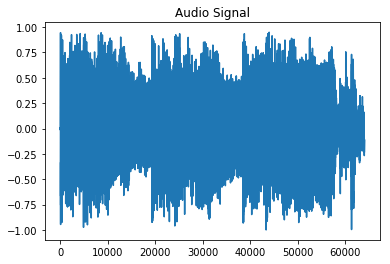

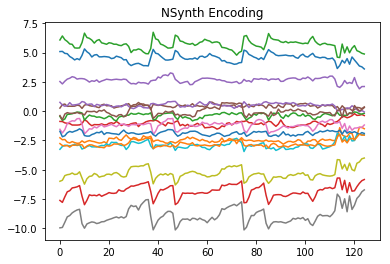

In [16]:
#@title Visualize Audio and Encoding { vertical-output: true, run: "auto" }
SoundFile = 3 #@param {type:"slider", min:0, max:10, step:1}
file_number = SoundFile

try:
  print(names[file_number])
  play(audio_list[file_number], sample_rate=SR)
  plt.figure()
  plt.plot(audio_list[file_number])
  plt.title('Audio Signal')

  plt.figure()
  plt.plot(z_list[file_number])
  plt.title('NSynth Encoding')
except Exception as e:
  print e

In [17]:
print('Total Iterations to Complete: %d\n' % SAMPLE_LENGTH)

encodings = np.array(z_list)
save_paths = ['/content/' + name + '.wav' for name in name_list]
fastgen.synthesize(encodings,
                   save_paths=save_paths,
                   checkpoint_path=ckpt_path,
                   samples_per_save=int(SAMPLE_LENGTH / 10))

W0224 11:52:13.465512 140320711051136 module_wrapper.py:139] From /tensorflow-1.15.2/python2.7/magenta/models/nsynth/utils.py:843: The name tf.FIFOQueue is deprecated. Please use tf.queue.FIFOQueue instead.



Total Iterations to Complete: 64000



In [18]:
for fname in save_paths:
  print('Downloading: %s' % fname.split('/')[-1])
  download(fname)

Downloading: recon_159119__cms4f__flute-play-c-04.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: recon_255878__jagadamba__female-voice-whispering-lab-geaks.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: recon_60055__juskiddink__cello-loop-2.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: recon_418526__audeption__fasching-fanfare-karnevals-tusch-tataa-long.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_159119__cms4f__flute-play-c-04_X_255878__jagadamba__female-voice-whispering-lab-geaks.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_159119__cms4f__flute-play-c-04_X_60055__juskiddink__cello-loop-2.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_159119__cms4f__flute-play-c-04_X_418526__audeption__fasching-fanfare-karnevals-tusch-tataa-long.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_255878__jagadamba__female-voice-whispering-lab-geaks_X_60055__juskiddink__cello-loop-2.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_255878__jagadamba__female-voice-whispering-lab-geaks_X_418526__audeption__fasching-fanfare-karnevals-tusch-tataa-long.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_60055__juskiddink__cello-loop-2_X_418526__audeption__fasching-fanfare-karnevals-tusch-tataa-long.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
print("Originals:\n")
for fname in file_list:
  synth_audio = utils.load_audio(fname,
                                 sample_length=SAMPLE_LENGTH,
                                 sr=SR)
  print(get_name(fname))
  play(synth_audio, sample_rate=SR)

for i, fname in enumerate(save_paths):
  if i == 0:
    print("Reconstructions:\n")
  if i == len(file_list):
    print("Interpolations:\n")
  synth_audio = utils.load_audio(fname,
                                 sample_length=SAMPLE_LENGTH,
                                 sr=SR)
  print(get_name(fname))
  play(synth_audio, sample_rate=SR)

Originals:

159119__cms4f__flute-play-c-04


255878__jagadamba__female-voice-whispering-lab-geaks


60055__juskiddink__cello-loop-2


418526__audeption__fasching-fanfare-karnevals-tusch-tataa-long


Reconstructions:

recon_159119__cms4f__flute-play-c-04


recon_255878__jagadamba__female-voice-whispering-lab-geaks


recon_60055__juskiddink__cello-loop-2


recon_418526__audeption__fasching-fanfare-karnevals-tusch-tataa-long


Interpolations:

interp_159119__cms4f__flute-play-c-04_X_255878__jagadamba__female-voice-whispering-lab-geaks


interp_159119__cms4f__flute-play-c-04_X_60055__juskiddink__cello-loop-2


interp_159119__cms4f__flute-play-c-04_X_418526__audeption__fasching-fanfare-karnevals-tusch-tataa-long


interp_255878__jagadamba__female-voice-whispering-lab-geaks_X_60055__juskiddink__cello-loop-2


interp_255878__jagadamba__female-voice-whispering-lab-geaks_X_418526__audeption__fasching-fanfare-karnevals-tusch-tataa-long


interp_60055__juskiddink__cello-loop-2_X_418526__audeption__fasching-fanfare-karnevals-tusch-tataa-long
